- [19.4 - Hierarchical Bayesian Approach](#19.4---Hierarchical-Bayesian-Approach)

## Chapter 19 - Metric Predicted Variable with One Nominal Predictor

In [71]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pmc
import theano.tensor as tt

from scipy.stats import norm
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}
plt.style.use('seaborn-white')

color = '#87ceeb'

In [72]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

In [76]:
# Plot the posterior predictive distribution on a swarmplot
def print_mustach(var, sd, j):
    for i in np.arange(0, len(var), int(len(var)*.1)):
        rv = norm(loc=var[i], scale=sd[i])
        xrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        plt.plot(-rv.pdf(xrange)*20+j, xrange, color=color)

### 19.4 - Hierarchical Bayesian Approach

In [73]:
df = pd.read_csv('data/FruitflyDataReduced.csv')
df.CompanionNumber = df.CompanionNumber.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
Longevity          125 non-null int64
CompanionNumber    125 non-null category
Thorax             125 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 2.1 KB


In [4]:
df.head()

   Longevity CompanionNumber  Thorax
0         35       Pregnant8    0.64
1         37       Pregnant8    0.68
2         49       Pregnant8    0.68
3         46       Pregnant8    0.72
4         63       Pregnant8    0.72

In [5]:
df.CompanionNumber.cat.categories

Index(['None0', 'Pregnant1', 'Pregnant8', 'Virgin1', 'Virgin8'], dtype='object')

In [6]:
cat_idx = df.CompanionNumber.cat.codes.values
cat_idx

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [7]:
df.CompanionNumber.value_counts()

Virgin8      25
Virgin1      25
Pregnant8    25
Pregnant1    25
None0        25
Name: CompanionNumber, dtype: int64

In [8]:
X = cat_idx
y = df.Longevity

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.CompanionNumber.cat.categories)

#### Model (Kruschke, 2015)

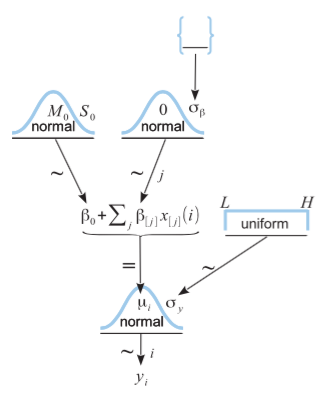

In [32]:
Image('images/fig19_2.png')

In [10]:
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pmc.Model() as model:
    
    aSigma = pmc.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pmc.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pmc.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pmc.Uniform('ySigma', ySD/100, ySD*10)
    y = pmc.Normal('y', a0 + a[X], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pmc.Deterministic('m', a0 + a)
    b0 = pmc.Deterministic('b0', tt.mean(m))
    b = pmc.Deterministic('b', m - b0) 

Applied log-transform to aSigma and added transformed aSigma_log_ to model.
Applied interval-transform to ySigma and added transformed ySigma_interval_ to model.


In [11]:
with model:
    trace = pmc.sample(1000)

Assigned NUTS to aSigma_log_
Assigned NUTS to a0
Assigned NUTS to a
Assigned NUTS to ySigma_interval_
 [-----------------100%-----------------] 1000 of 1000 complete in 308.4 sec

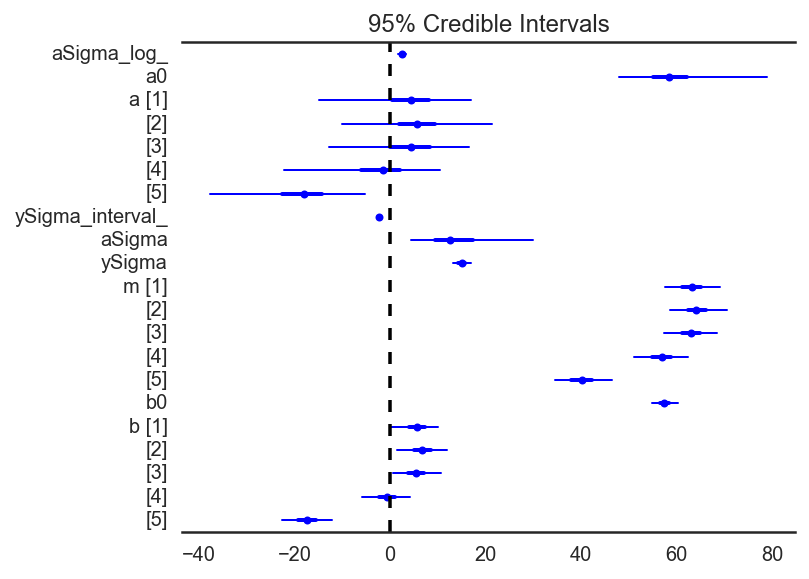

In [12]:
pmc.forestplot(trace);

In [13]:
pmc.df_summary(trace)

             mean        sd  mc_error    hpd_2.5   hpd_97.5
a0      58.852130  7.045565  0.407964  48.004626  79.071028
a__0     4.223320  7.498680  0.408739 -14.827621  17.048225
a__1     5.430012  7.328762  0.395180  -9.956081  21.378829
a__2     4.119616  7.367368  0.399568 -12.840395  16.525849
a__3    -2.015141  7.640930  0.430082 -22.127979  10.493982
a__4   -18.694203  7.749226  0.428243 -37.719806  -5.292491
aSigma  14.794660  8.445334  0.545282   4.495034  29.955439
ySigma  15.142758  2.240219  0.096675  13.213725  17.064560
m__0    63.075450  3.580075  0.107751  57.535642  69.047095
m__1    64.282142  2.964245  0.081924  58.753709  70.551730
m__2    62.971746  2.864815  0.090603  57.499040  68.591467
m__3    56.836989  3.061217  0.103898  51.035480  62.518076
m__4    40.157926  3.137853  0.107937  34.681281  46.496859
b0      57.464851  1.411390  0.041299  54.969462  60.292987
b__0     5.610600  2.997066  0.088343   0.067472  10.097786
b__1     6.817292  2.788140  0.089838   

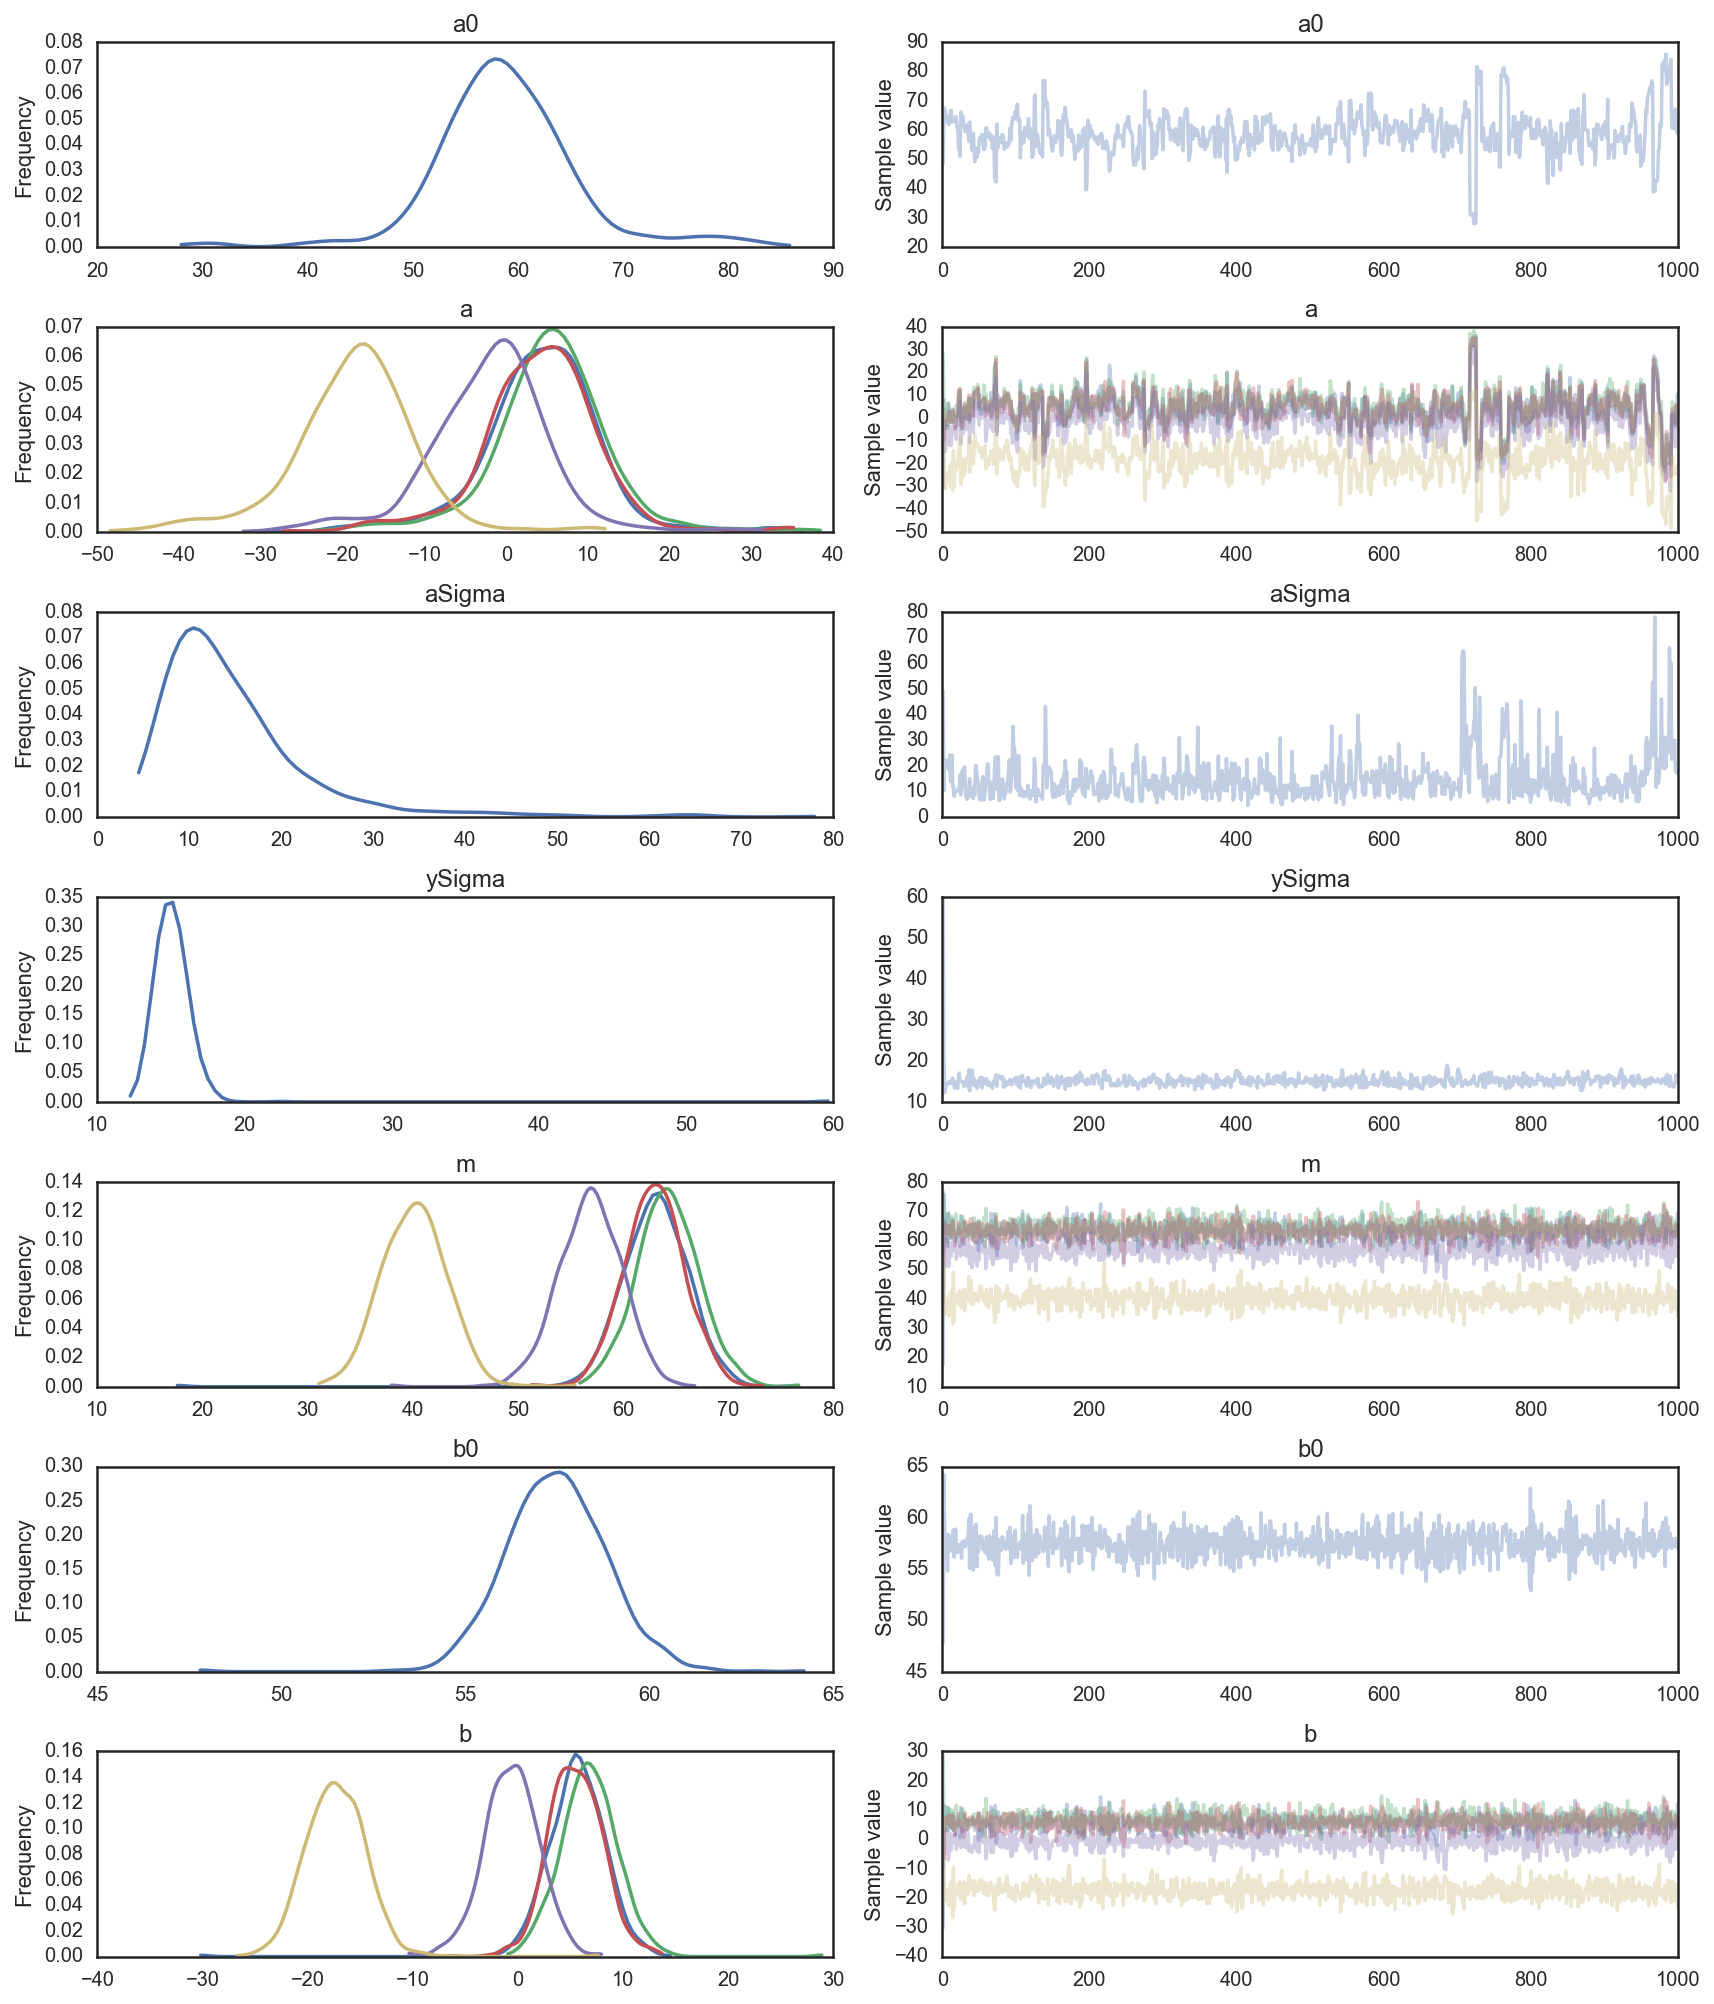

In [74]:
pmc.traceplot(trace);

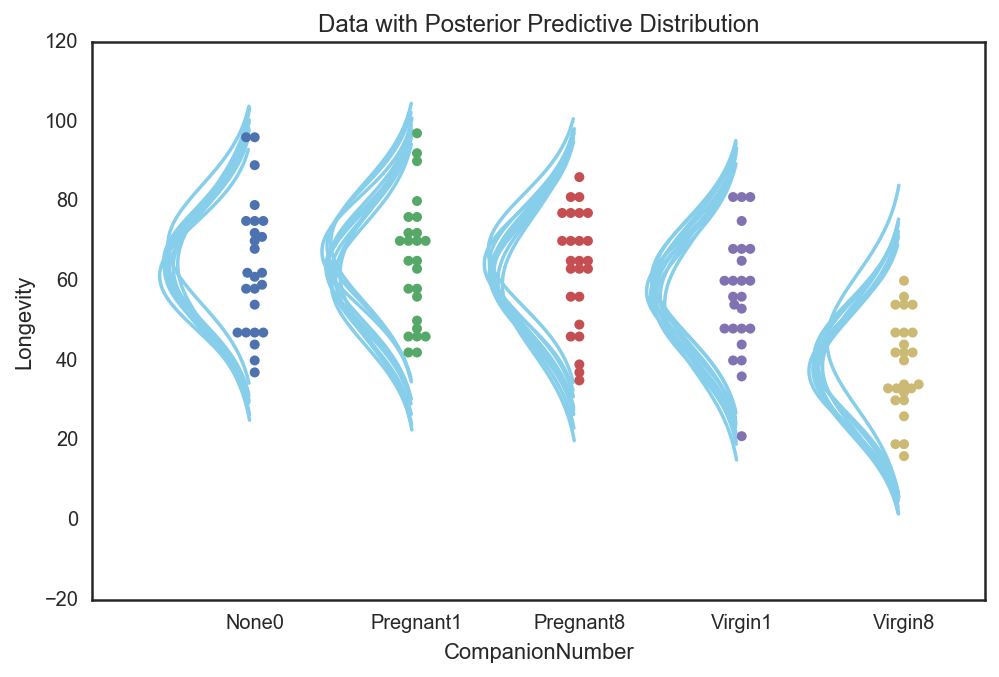

In [84]:
burnin = 200

None0 = trace['m'][burnin:,0]
Pregnant1 = trace['m'][burnin:,1]
Pregnant8 = trace['m'][burnin:,2]
Virgin1 = trace['m'][burnin:,3]
Virgin8 = trace['m'][burnin:,4]
scale = trace['ySigma'][burnin:]

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.set_title('Data with Posterior Predictive Distribution')

sns.swarmplot('CompanionNumber', 'Longevity', data=df, ax=ax);
ax.set_xlim(xmin=-1)

for i, grp in enumerate([None0, Pregnant1, Pregnant8, Virgin1, Virgin8]):
    print_mustach(grp, scale, i)

#### Contrasts

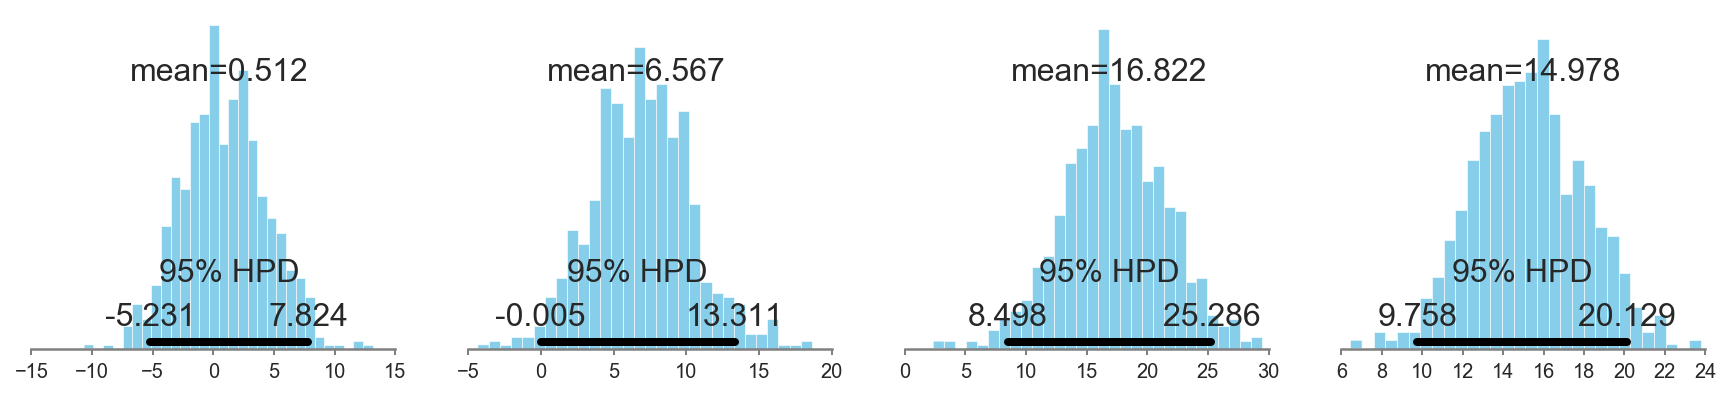

In [85]:
fig, axes = plt.subplots(1,4, figsize=(15,3))

pmc.plot_posterior(np.mean([Pregnant1, Pregnant8], axis=0)-None0, color=color, ax=axes[0])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-Virgin1, color=color, ax=axes[1])
pmc.plot_posterior(Virgin1-Virgin8, color=color, ax=axes[2])
pmc.plot_posterior(np.mean([Pregnant1, Pregnant8, None0], axis=0)-np.mean([Virgin1, Virgin8], axis=0), color=color, ax=axes[3])